**I worked on this project by myself but used some of Professor Bianco's functions and techniques<br>
I have incorporated Prof Bianco's comments into this assignment but have not completed my statistical test.**

# Homework 8, Assignment 2
Based on a workbook written by Federica B. Bianco @fedhere for NYU CUSP PUI

## Idea: Women ride bikes more at night than men do.


## Null Hypothesis: The proportion of men biking at night (defined as trips starting after 9PM or ending before 6AM) is the same or higher  than the proportion of women biking at night.


# $H_0$ : $\frac{W_{\mathrm{night}}}{W_{\mathrm{total}}} - \frac{M_{\mathrm{night}}}{M_{\mathrm{total}}} <= 0 $<br>
# $H_1$ : $\frac{W_{\mathrm{night}}}{W_{\mathrm{total}}} - \frac{M_{\mathrm{night}}}{M_{\mathrm{total}}} > 0$

# $\alpha = 0.05$<br>
**I want the probability of getting a result at least as significant as mine to be less then 5%**

In [212]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats
import os

%pylab inline

if os.getenv ('PUI2018') is None:
    print ("Must set env variable PUI20181")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI20182")


#import json
#s = json.load( open(os.getenv('PUI2018') + "/fbb_matplotlibrc.json") )
#pl.rcParams.update(s)


Populating the interactive namespace from numpy and matplotlib
Must set env variable PUI20181


In [36]:
# move the downloaded data to PUI data
print("PUIdata", os.getenv("PUIDATA"))

#create the env variable if missing-- needed to create
#added PUI2018 to path 
os.environ["PUIDATA"] = "%s/PUI2018/PUIdata"%os.getenv("HOME")

print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/ram844/PUI2018/PUIdata
PUIdata /nfshome/ram844/PUI2018/PUIdata


## I am starting with a single month of data:  reading data from citibike csv file from July 2015

### download and move  data to PUIDATA
# NOTE: 
# 1. access to data from within the notebook _is required_
# 2. if data is downloaded it _must_ be stored in a directory pointed to by the environmental variable PUIDATA

In [37]:
# Adapted from homework 4 citibikes example to adjust for environment variable

### this looks for existing files, downloads a file if none is there, unzips it, and moves it.
### As long as 
### 1) your research is reproducible: we can access the same file as you without having to ask you for the file
### 2) and your data is stored in a directory pointed to by the env variable PUIDATA 
### you will be fine. We already explored how to download data in other notebooks!

def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will check that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [38]:
datestring = '201506'
getCitiBikeCSV(datestring)

file in place, you can continue


In [39]:
# df is the dataframe where the content of the csv file is stored
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')

In [40]:
#make the starttime and stoptime into datetime objects
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1338,2015-06-01 00:00:00,2015-06-01 00:22:00,128,MacDougal St & Prince St,40.727103,-74.002971,2021,W 45 St & 8 Ave,40.759291,-73.988597,20721,Subscriber,1984.0,1
1,290,2015-06-01 00:00:00,2015-06-01 00:05:00,438,St Marks Pl & 1 Ave,40.727791,-73.985649,312,Allen St & E Houston St,40.722055,-73.989111,21606,Subscriber,1997.0,1
2,634,2015-06-01 00:01:00,2015-06-01 00:11:00,383,Greenwich Ave & Charles St,40.735238,-74.000271,388,W 26 St & 10 Ave,40.749718,-74.002950,16595,Subscriber,1993.0,1
3,159,2015-06-01 00:01:00,2015-06-01 00:04:00,361,Allen St & Hester St,40.716059,-73.991908,531,Forsyth St & Broome St,40.718939,-73.992663,16949,Subscriber,1981.0,1
4,1233,2015-06-01 00:02:00,2015-06-01 00:22:00,382,University Pl & E 14 St,40.734927,-73.992005,532,S 5 Pl & S 4 St,40.710451,-73.960876,17028,Customer,NaN,0


In [41]:
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

In [42]:
#dropping all columns except starttime, stoptime, and gender
df.drop(['tripduration', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year'], axis=1, inplace=True)

In [43]:
df.head()

,starttime,stoptime,gender
0,2015-06-01 00:00:00,2015-06-01 00:22:00,1
1,2015-06-01 00:00:00,2015-06-01 00:05:00,1
2,2015-06-01 00:01:00,2015-06-01 00:11:00,1
3,2015-06-01 00:01:00,2015-06-01 00:04:00,1
4,2015-06-01 00:02:00,2015-06-01 00:22:00,0


In [44]:
#creating new starthour and stophour columns based on hour value of starttime and stoptime 
df = df.assign(starthour=df['starttime'].dt.hour) 
df = df.assign(stophour=df['stoptime'].dt.hour)
#creating night flag cloumn for trips starting after 9PM or ending before 6AM
df['night'] = np.where(df['starthour']>=21, 'yes', np.where(df['stophour']<6,'yes', 'no'))
df.tail()

,starttime,stoptime,gender,starthour,stophour,night
941214,2015-06-30 23:59:00,2015-07-01 00:17:00,1,23,0,yes
941215,2015-06-30 23:59:00,2015-07-01 00:18:00,0,23,0,yes
941216,2015-06-30 23:59:00,2015-07-01 00:58:00,0,23,0,yes
941217,2015-06-30 23:59:00,2015-07-01 00:13:00,1,23,0,yes
941218,2015-06-30 23:59:00,2015-07-01 00:10:00,1,23,0,yes


In [45]:
#checking the size of this dataframe before dropping rows with no gender data
#df['night'].value_counts()
df.shape

(941219, 6)

In [46]:
#dropping rows with no gender data and checking size
df = df.drop(df[df.gender == 0].index)
df.shape

(810246, 6)

In [156]:
df['men_night'] = np.where(df['night']=='yes', np.where(df['gender']==1,1,0),0)
df['women_night'] = np.where(df['night']=='yes', np.where(df['gender']==2,1,0),0)
df.tail()

,starttime,stoptime,gender,starthour,stophour,night,men_night,women_night
941211,2015-06-30 23:59:00,2015-07-01 00:02:00,2,23,0,yes,0,1
941213,2015-06-30 23:59:00,2015-07-01 00:02:00,1,23,0,yes,1,0
941214,2015-06-30 23:59:00,2015-07-01 00:17:00,1,23,0,yes,1,0
941217,2015-06-30 23:59:00,2015-07-01 00:13:00,1,23,0,yes,1,0
941218,2015-06-30 23:59:00,2015-07-01 00:10:00,1,23,0,yes,1,0


In [197]:
#new dataframe set equal to grouping of by gender and night
summary = df.groupby(['gender','night']).count()
summary = summary.reset_index()
summary

,gender,night,starttime,stoptime,starthour,stophour,men_night,women_night
0,1,no,557912,557912,557912,557912,557912,557912
1,1,yes,63679,63679,63679,63679,63679,63679
2,2,no,172160,172160,172160,172160,172160,172160
3,2,yes,16495,16495,16495,16495,16495,16495


In [198]:
summary.drop(['stoptime','starthour','stophour','men_night','women_night'], axis=1, inplace=True)
summary

,gender,night,starttime
0,1,no,557912
1,1,yes,63679
2,2,no,172160
3,2,yes,16495


In [199]:
#rename column to count
summary.rename(index=str, columns={"starttime":"count"}, inplace=True)
# create proportions column
summary = summary.assign(proportion = summary['count']/summary['count'].sum())
summary

,gender,night,count,proportion
0,1,no,557912,0.688571
1,1,yes,63679,0.078592
2,2,no,172160,0.212479
3,2,yes,16495,0.020358


In [200]:
#df = df.drop(df[df.gender == 0].index)
summary = summary.drop(summary[summary.night == 'no'].index)
summary.drop(['night','count'], axis=1, inplace=True)



In [201]:
summary['gender'] = summary['gender'].map({1:'male',2:'female'})
summary

,gender,proportion
1,male,0.078592
3,female,0.020358


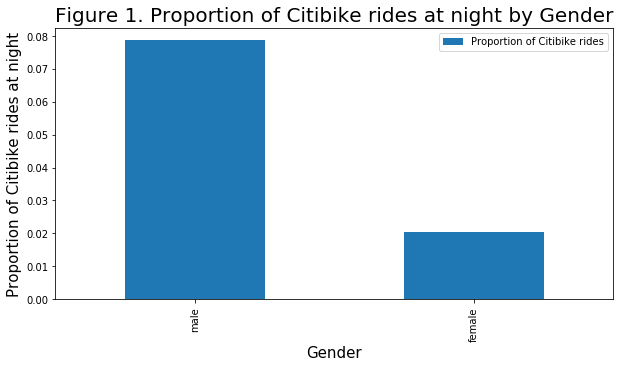

In [211]:
ax = summary.plot.bar('gender', figsize=(10,5))
ax.set_xlabel("Gender", fontsize=15)
ax.set_ylabel("Proportion of Citibike rides at night", fontsize=15)
ax.set_title("Figure 1. Proportion of Citibike rides at night by Gender", fontsize=20)
ax.legend(["Proportion of Citibike rides"])
